# Πρώτη Εργασία
## Διερευνώντας τον καιρό στην Αθήνα
---
> Αλέξανδρος Πετρίδης <br/>
> al1998petridis@gmail.com

### Εγκατάσταση βιβλιοθηκών για το συγκεκριμένο jupyter notebook 

In [1]:
%pip install -r requirements.txt

  Using cached entrypoints-0.4-py3-none-any.whl (5.3 kB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)
  Using cached ipykernel-6.13.0-py3-none-any.whl (131 kB)
  Using cached ipython-8.3.0-py3-none-any.whl (750 kB)
  Using cached jupyter_client-7.3.0-py3-none-any.whl (130 kB)
  Using cached jupyter_core-4.10.0-py3-none-any.whl (87 kB)
  Using cached pexpect-4.8.0-py2.py3-none-any.whl (59 kB)
  Using cached Pillow-9.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached prompt_toolkit-3.0.29-py3-none-any.whl (381 kB)
  Using cached Pygments-2.12.0-py3-none-any.whl (1.1 MB)
  Using cached pyparsing-3.0.8-py3-none-any.whl (98 kB)
  Attempting uninstall: fonttools
    Found existing installation: fonttools 4.31.2
    Uninstalling fonttools-4.31.2:
      Successfully uninstalled fonttools-4.31.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: jupyter-core
  

### Εισαγωγή χρήσιμων βιβλιοθηκών

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import cycler

### Συγκέντρωση των δεδομένων

In [3]:
# Data from National Oceanic and Atmospheric Administration's (NOAA) National Centers for Environmental Information
data_hel = pd.read_csv('noaa_hellinikon_1995_2020.csv')
data_hel['DATE'] = pd.to_datetime(data_hel['DATE'])
data_hel = data_hel[['DATE', 'TAVG']]
data_hel = data_hel.sort_values(by=('DATE'))

# Data from hellenic data service
data_ath = pd.read_csv('athens.csv')
data_ath.set_axis(['DATE', 'TAVG', 'max_temp', 'min_temp', 'mean_hum', 'max_hum', 'min_hum',
                'mean_pres', 'max_pres', 'min_pres', 'daily_rainfall', 'mean_wind_speed', 'dom_wind_dir', 'wind_gust'],
                axis=1, inplace=True)
data_ath[data_ath['TAVG'] == "---"] = np.nan
data_ath['TAVG'] = data_ath['TAVG'].astype("float")
data_ath['DATE'] = pd.to_datetime(data_ath['DATE'])
data_ath = data_ath.sort_values(by=('DATE'))
imputer = KNNImputer(missing_values=np.nan, weights='distance')
data_ath['TAVG'] = imputer.fit_transform(data_ath['TAVG'].values.reshape(-1, 1))
data_ath = data_ath.dropna(subset=['DATE'])

# Join dataframes
data = data_hel.fillna(data_ath[['DATE', 'TAVG']])
imputer = KNNImputer(missing_values=np.nan, weights='distance')
data['TAVG'] = imputer.fit_transform(data['TAVG'].values.reshape(-1, 1))


Παρατηρήσεις:

* Τα δεδομένα του dataset `data_hel` περιέχουν στην στήλη με την μέση θερμοκρασία 2311 τιμές `NaN`.

* Στα δεδομένα του dataset `data_ath` οι τιμές της μέσης θερμοκρασίας δεν είναι float αλλά object και οι `NaN` τιμές συμβολίζονται με `"---"`

* Ακόμα στο `data_ath` οι 3 τιμές `NaN` για τη μέση θερμοκρασία θα γεμίσουν μέσω μηχανισμών *καταλογισμού* και πιο συγκεκριμένα με την στρατηγική του μέσου όρου των Κ-Κοντινών Γειτόνων.

* Επίσης στο `data_ath` παρατηρείται ότι υπάρχουν και `NaN` τιμές της στήλης `DATE`, αυτές απλά θα διαγραφούν.

* Στο τελικό σύνολο δεδομένων `data` οι `NaN` τιμές που δεν υπάρχουν σε κανένα από τα δύο σύνολα θα γεμίσουν με την ίδια λογική καταλογισμού με τη στρατηγική του μέσου όρου Κ κοντινών γειτόνων για τις `NaN` τιμές που παραμένουν μετά το γέμισμα των τιμών `NaN` του dataset `data_hel` με το `data_ath`.

### Απόκλιση Καλοκαιρινών Θερμοκρασιών

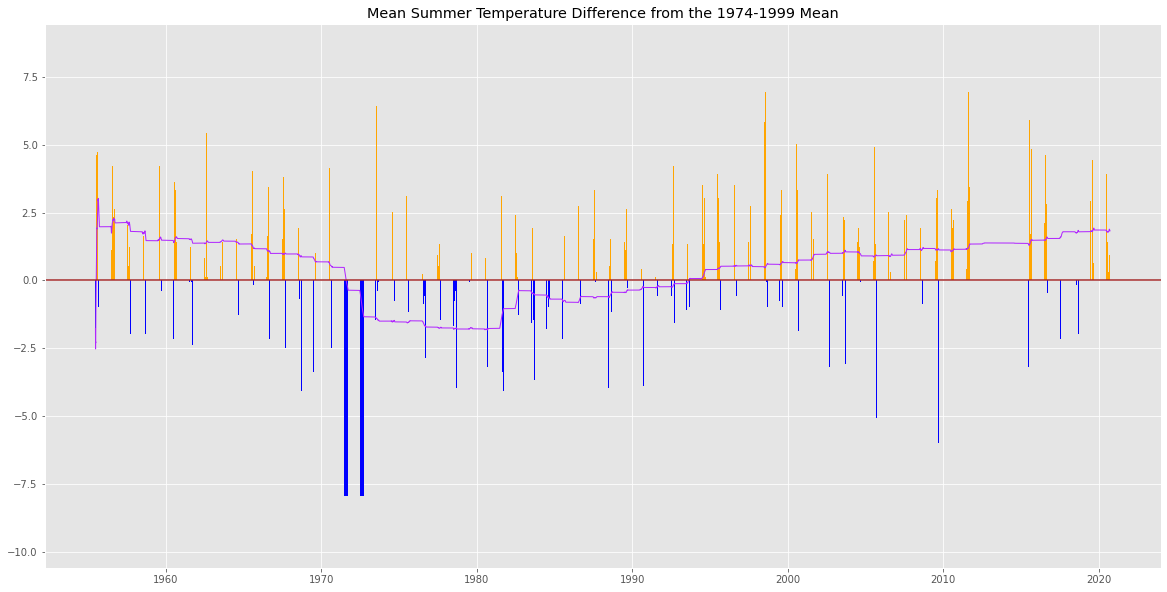

In [4]:
# Data for question 2
data_for_2 = data.copy()
data_for_2['date_offset'] = (data_for_2.DATE.dt.month*100 + data_for_2.DATE.dt.day - 320)%1300
data_for_2['season'] = pd.cut(data_for_2['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])
data_for_2 = data_for_2[data_for_2['season'] == 'summer']

## Reference Temperature
temp_ref = data_for_2.loc[(data_for_2['DATE'] >= '1974-01-01') & (data_for_2['DATE'] <= '1999-01-01')].copy().TAVG.mean()
data_for_2['temp_diff'] = data_for_2['TAVG'] - temp_ref 
data_for_2['10years_roll_avg'] = data_for_2['temp_diff'].rolling(930, min_periods=0).mean()      ## Summer year is 93 days

## for NaN values think something else like mean temp of next 920 if not possible to find from last
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.bar(data_for_2['DATE'], data_for_2['temp_diff'], color=np.where(data_for_2['temp_diff']<0, 'blue', 'orange'))
plt.plot(data_for_2['DATE'], data_for_2['10years_roll_avg'], color='#B026FF' , linewidth=1, linestyle='-')
plt.axhline(0, color='brown')
plt.title('Mean Summer Temperature Difference from the 1974-1999 Mean')
plt.show()

Ερμηνία Γραφήματος:

* Στο γράφημα παρατηρείται πως οι περισσότερες χαμηλές θερμοκρασίες βρίσκονταν ανάμεσα στο `1970` και `1980`, ενώ από το `1995` περίπου παρατηρείται πως δεν υπάρχουν τόσες χαμηλές αλλά ούτε με τέτοια ένταση θερμοκρασίες.

* Ακόμα παρατηρείται ότι η μέση θερμοκρασία ξεκινάει από υψηλές και καταλήγει σε υψηλές τιμές, όμως ενδιάμεσα έχει πτώση.



### Εξέλιξη Ημερήσιων Θερμοκρασιών

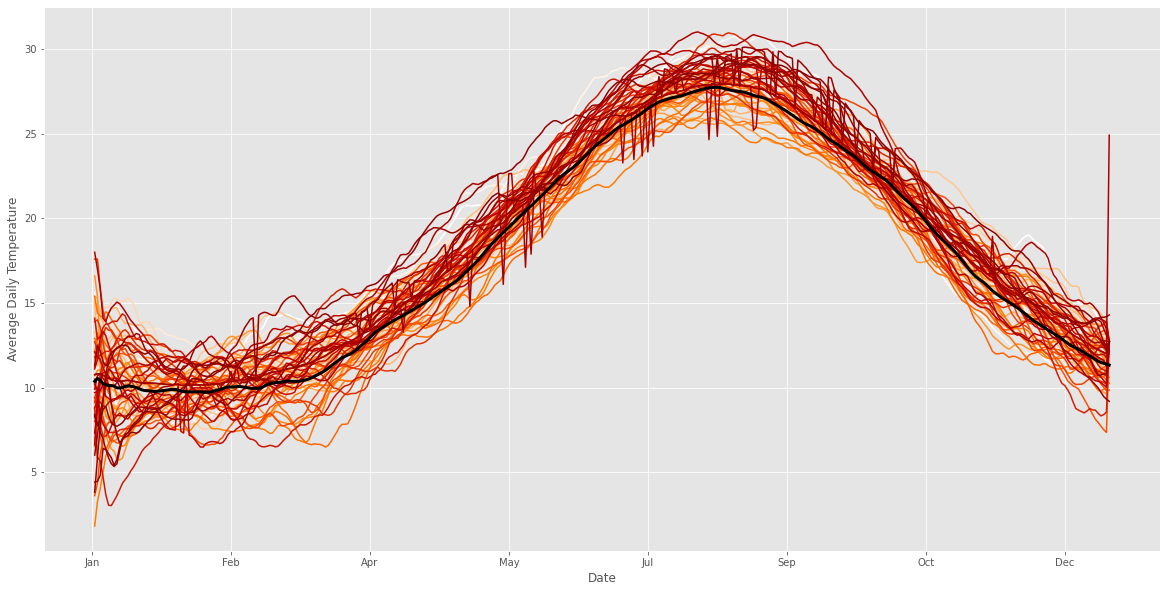

In [5]:
# Data for question 3
data_for_3 = data.copy()
data_for_3['year'] = data_for_3['DATE'].dt.year
data_for_3['doy'] = data_for_3['DATE'].dt.dayofyear
data_for_3['TAVG_norm'] = data_for_3.groupby('year')['TAVG'].rolling(30, min_periods=0).mean().reset_index()['TAVG']
data_for_3 = pd.pivot_table(data_for_3, index=['doy'], columns=['year'], values=['TAVG_norm'])
data_for_3 = data_for_3.where(data_for_3.notna(), data_for_3.mean(axis=1), axis=0)
data_for_3.drop(columns=('TAVG_norm', 1972), inplace=True)
data_for_3.drop(columns=('TAVG_norm', 1971), inplace=True)


## Mean day temperature of 1974-1999 period, normalized by 30-day rolling average
data_mean = data.copy()
data_mean['year'] = data_mean['DATE'].dt.year
data_mean['doy'] = data_mean['DATE'].dt.dayofyear
data_mean = pd.pivot_table(data_mean, index=['doy'], columns=['year'], values=['TAVG'])
data_mean = data_mean.where(data_mean.notna(), data_mean.mean(axis=1), axis=0)
data_mean = data_mean.iloc[:,19:45]


# ####################### Data exploration #######################
# years = data_for_3['year'].unique()
# per_year = {}

# for id, year in enumerate(years):
#     per_year[id] = data_for_3.loc[data_for_3.year==year, :]     ## 0 is 1955

# incomplete_years = []
# for i,y in enumerate(years):
#     if len(per_year[i]) < 365:
#         incomplete_years.append(y)

# print('Incomplete years on dataset:', incomplete_years)
# print('Len of incomplete year:')
# print('2006 -', len(per_year[51]))
# print('2007 -', len(per_year[52]))
# print('2013 -', len(per_year[57]))
# print('2014 -', len(per_year[58]))
# print('2017 -', len(per_year[61]))
# print('2018 -', len(per_year[62]))

# for i in range(66):   ## find if a column has more than 2 same values
#     if sum([data_for_3.iloc[:,i] == data_for_3.iloc[1,i]]).sum() > 2:
#         print(i)
# for i in range(65):   ## find if a column has more than 2 same values after rolling
#     for j in range(366):
#         if sum([data_for_3.iloc[:,i] == data_for_3.iloc[j,i]]).sum() > 2:
#             print(data_for_3.iloc[j,i])
# for i in range(65):
#     if (sum(data_for_3.iloc[:,i].isin([18.32581259410149])) > 2):
#         print(i)
# ################################################################


plt.style.use('ggplot')
color = plt.cm.gist_heat_r(np.linspace(0, 1,100))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_for_3)
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.set_ylabel('Average Daily Temperature')
ax.set_xlabel('Date')
ax.plot(data_mean.mean(axis=1).rolling(30, min_periods=0).mean(), color='k', linewidth=3)


Ερμηνία Εικόνας:

* Παρατηρείται αυτό που ήταν και αναμενόμενο, δηλαδή πως τους μήνες από τον `Μάιο` μέχρι και τον `Οκτώβριο` η μέση θερμοκρασία ημέρας αυξάνεται.


Παρατηρήσεις:

* Στο dataset παρατηρείται ότι υπάρχουν 7 χρονιές με αριθμό ημερών μικρότερο του 365 και 15 χρονιές με μεγαλύτερο το 365. Όμως οι χρονιές με μεγαλύτερο του 365 έχουν 366 και αυτό σημαίνει ότι είναι δίσεκτα έτη, οπότε δεν έχουμε πρόβλημα με αυτές τις χρονιές.
* Για τις 7 χρονιές με αριθμό μικρότερο του 365 έχουμε αναλυτικά τις παρακάτω τιμές. Στις χρονιές που υπάρχει το μεγαλύτερο πρόβλημα είναι τις χρονιές 2012, 2013 και 2014.</br>
    Χρονιά - Μέρες:</br>
    2006 - 363</br>
    2007 - 364</br>
    <em>2012 - 160 (λείπουν οι μήνες 7-12)</em></br>
    <em>2013 - 10</em></br>
    <em>2014 - 98 (λείπουν οι 7 πρώτοι μήνες)</em></br>
    2017 - 342</br>
    2018 - 364</br>
* Θα γεμίσουμε αυτές τις κενές τιμές με τον μέσο όρο της κάθε σειράς, δηλαδή με την μέση θερμοκρασία κάθε χρόνου της συγκεκριμένης μέρας. Οι χρονιές που έχουν αρκετές NaN τιμές δεν
* Ακόμα παρατηρείται ότι τα δεδομένα για την χρονιά `1972` είναι όλα ίδια με την τιμή `18.325813` και τέλος, μετά την εξομάλυνση των δεδομένων με τον κινούμενο μέσο όρο των 30 ημερών, έχουμε παρόμοια συμπεριφορά στην χρονιά `1971` για τις τιμές μετά τον Μάιο. Θα διαγράψουμε αυτές τις δύο χρονιές για να μην υπάρχουν οριζόντες ευθείες γραμμές στο διάγραμμά μας.

